# Clasificare flori cu MobileNetV3

## 1. Introducere

Acest proiect realizează clasificarea a 6 tipuri de flori (daisy, lavander, lilies, roses, sunflower, tulips) pe baza imaginilor, folosind arhitectura MobileNetV3. Scannerul de flori trebuie să fie ușor, rapid și eficient, de aceea am ales această rețea optimizată.

---

## 2. De ce MobileNetV3?

* **Eficiență computațională**: blocuri depthwise separă convoluțiile, reducând numărul de parametri.
* **Performanță**: include Squeeze-and-Excitation (SE) și activare Hardswish îmbunătățite.
* **Portabilitate**: potrivită pentru aplicații mobile și edge.

---

## 3. Pregătirea datelor

1. **Structură dataset**:

   * `train/`: 600 imagini (100 per clasă)
   * `test/`: 120 imagini (20 per clasă)

2. **Calcul mean & std**:

   ```python
   # resize, crop, ToTensor
   # buclă PyTorch pentru a acumula sumă și sumă pătratică
   mean = [0.5613, 0.4627, 0.3942]
   std  = [0.2408, 0.2174, 0.2303]
   ```

3. **Transformări**:

   * **Train**: augmentări (crop, flip, jitter, rotație) + `Normalize(mean, std)`
   * **Test**: resize + center crop + `Normalize(mean, std)`

---

## 4. Arhitectura

* **ConvBlock**: 1×1 pointwise + 3×3 depthwise + BatchNorm + activare (ReLU sau Hardswish).
* **SeBlock**: Squeeze-and-Excitation (ratio=¼) cu AdaptiveAvgPool + Hardsigmoid.
* **BNeck**: expandare → depthwise conv → SE (opțional) → proiecție + skip connection dacă stride=1.
* **MobileNetV3-Large**: succesiune de BNeck-uri conform tabelului din paper.
* **Head**: ConvBlock + AdaptiveAvgPool + ConvBlock fără BN + Dropout(0.8) + Conv2d final.

---

## 5. Antrenare și evaluare

* **Optimizer**: AdamW(lr=1e-3, weight\_decay=1e-4)
* **Loss**: CrossEntropyLoss
* **Epoci**: 30
* **Metrică**: acuratețe în procente

**Flux esențial**:

```python
# buclă de antrenament
for imgs, tgt in trainloader:
    optimizer.zero_grad()
    out = model(imgs)
    loss = criterion(out, tgt)
    loss.backward(); optimizer.step()
# computează și printează: Train acc: xx.xx%

# evaluare fără gradient
with torch.no_grad():
  for imgs, tgt in testloader:
      out = model(imgs); loss = criterion(out, tgt)
# computează și printează: Test acc: xx.xx%
```

* Acuratețea este exprimată procentual (`Train acc: 54.33%`, `Test acc: 68.00%`).
* Modelul cu cea mai bună acuratețe pe test este salvat automat (`best_model.pth`).

## 6. Rezultate obținute

* **Max test accuracy**: \~76.7% (epoch 19)
* **Train accuracy** at final epoch: 74.0%
* **Trend**: train acc crescut de la \~19% (epoch1) la \~74%, test acc de la \~16.7% la \~76.7% până în epoch 19, apoi s-a stabilizat între 72–75%.
* **Clase puternice**:

  * `lavander`, `sunflower`: recall ≥ 0.85 în majoritatea epocilor tardive.
  * `roses`: recall constant ≥ 0.9 în epoci multiple.
* **Clase slabe**:

  * `lilies`: recall scăzut (0.1–0.5).
  * `tulips`: recall variabil (0.3–0.6).

---

## 7. Concluzii și pași următori

* MobileNetV3 oferă un echilibru bun între viteză și acuratețe.
* Pentru îmbunătățire:

  * Utilizare greutăți pretrained ImageNet.
  * Ajustare Dropout (ex: 0.2–0.5) și scheduler LR.
  * Vizualizare Grad-CAM și analiză erroare.
  * Creșterea dataset-ului cu augmentări suplimentare.

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_DIR = '/content/drive/MyDrive/dataset'

# ----------------------------------------
# 1) Compute mean & std on “raw” images
# ----------------------------------------
raw_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_raw = datasets.ImageFolder(
    root=f'{DATA_DIR}/train',
    transform=raw_transform,
)
train_raw_loader = DataLoader(
    train_raw,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

for images, _ in train_raw_loader:
    B, C, H, W = images.shape
    images = images.view(B, C, -1)
    mean += images.mean(dim=2).sum(dim=0)
    std  += images.std(dim=2).sum(dim=0)
    nb_samples += B

mean /= nb_samples
std  /= nb_samples

print(f'Computed mean: {mean.tolist()}')
print(f'Computed std:  {std.tolist()}')

# ----------------------------------------
# 2) Define final transforms
# ----------------------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5,1.0), ratio=(0.75,1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4,
                           saturation=0.4, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

# ----------------------------------------
# 3) Create datasets & dataloaders
# ----------------------------------------
trainset = datasets.ImageFolder(
    root=f'{DATA_DIR}/train',
    transform=train_transform
)
trainloader = DataLoader(
    trainset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

testset = datasets.ImageFolder(
    root=f'{DATA_DIR}/test',
    transform=test_transform
)
testloader = DataLoader(
    testset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Verify classes
classes = trainset.classes
print('Classes:', classes)


Computed mean: [0.5613479018211365, 0.4627373218536377, 0.3941650986671448]
Computed std:  [0.24079638719558716, 0.217417910695076, 0.2303313910961151]
Classes: ['daisy', 'lavander', 'lilies', 'roses', 'sunflower', 'tulips']


In [ ]:
import torch
import torch.nn as nn
from torch import Tensor

class ConvBlock(nn.Module):
    # Convolution Block with Conv2d layer, Batch Normalization and ReLU. Act is an activation function.
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        kernel_size : int,
        stride : int,
        act = nn.ReLU(),
        groups = 1,
        bn = True,
        bias = False
        ):
        super().__init__()

        # If k = 1 -> p = 0, k = 3 -> p = 1, k = 5, p = 2.
        padding = kernel_size // 2
        self.c = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.act = act

    def forward(self, x: Tensor) -> Tensor:
        return self.act(self.bn(self.c(x)))


class SeBlock(nn.Module):
    # Squeeze and Excitation Block.
    def __init__(
        self,
        in_channels : int
        ):
        super().__init__()

        C = in_channels
        r = C // 4
        self.globpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(C, r, bias=False)
        self.fc2 = nn.Linear(r, C, bias=False)
        self.relu = nn.ReLU()
        self.hsigmoid = nn.Hardsigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # x shape: [N, C, H, W].
        f = self.globpool(x)
        f = torch.flatten(f,1)
        f = self.relu(self.fc1(f))
        f = self.hsigmoid(self.fc2(f))
        f = f[:,:,None,None]
        # f shape: [N, C, 1, 1]

        scale = x * f
        return scale

# BNeck
class BNeck(nn.Module):
    # MobileNetV3 Block
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        kernel_size : int,
        exp_size : int,
        se : bool,
        act : torch.nn.modules.activation,
        stride : int
        ):
        super().__init__()

        self.add = in_channels == out_channels and stride == 1

        self.block = nn.Sequential(
            ConvBlock(in_channels, exp_size, 1, 1, act),
            ConvBlock(exp_size, exp_size, kernel_size, stride, act, exp_size),
            SeBlock(exp_size) if se == True else nn.Identity(),
            ConvBlock(exp_size, out_channels, 1, 1, act=nn.Identity())
        )

    def forward(self, x: Tensor) -> Tensor:
        res = self.block(x)
        if self.add:
            res = res + x

        return res

""" MobileNetV3 """
class MobileNetV3(nn.Module):
    def __init__(
        self,
        config_name : str,
        in_channels = 3,
        classes = 1000
        ):
        super().__init__()
        config = self.config(config_name)

        # First convolution(conv2d) layer.
        self.conv = ConvBlock(in_channels, 16, 3, 2, nn.Hardswish())
        # Bneck blocks in a list.
        self.blocks = nn.ModuleList([])
        for c in config:
            kernel_size, exp_size, in_channels, out_channels, se, nl, s = c
            self.blocks.append(BNeck(in_channels, out_channels, kernel_size, exp_size, se, nl, s))

        # Classifier
        last_outchannel = config[-1][3]
        last_exp = config[-1][1]
        out = 1280 if config_name == "large" else 1024
        self.classifier = nn.Sequential(
            ConvBlock(last_outchannel, last_exp, 1, 1, nn.Hardswish()),
            nn.AdaptiveAvgPool2d((1,1)),
            ConvBlock(last_exp, out, 1, 1, nn.Hardswish(), bn=False, bias=True),
            nn.Dropout(0.8),
            nn.Conv2d(out, classes, 1, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        for block in self.blocks:
            x = block(x)

        x = self.classifier(x)
        return torch.flatten(x, 1)


    def config(self, name):
        HE, RE = nn.Hardswish(), nn.ReLU()
        # [kernel, exp size, in_channels, out_channels, SEBlock(SE), activation function(NL), stride(s)]
        large = [
                [3, 16, 16, 16, False, RE, 1],
                [3, 64, 16, 24, False, RE, 2],
                [3, 72, 24, 24, False, RE, 1],
                [5, 72, 24, 40, True, RE, 2],
                [5, 120, 40, 40, True, RE, 1],
                [5, 120, 40, 40, True, RE, 1],
                [3, 240, 40, 80, False, HE, 2],
                [3, 200, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 480, 80, 112, True, HE, 1],
                [3, 672, 112, 112, True, HE, 1],
                [5, 672, 112, 160, True, HE, 2],
                [5, 960, 160, 160, True, HE, 1],
                [5, 960, 160, 160, True, HE, 1]
        ]

        small = [
                [3, 16, 16, 16, True, RE, 2],
                [3, 72, 16, 24, False, RE, 2],
                [3, 88, 24, 24, False, RE, 1],
                [5, 96, 24, 40, True, HE, 2],
                [5, 240, 40, 40, True, HE, 1],
                [5, 240, 40, 40, True, HE, 1],
                [5, 120, 40, 48, True, HE, 1],
                [5, 144, 48, 48, True, HE, 1],
                [5, 288, 48, 96, True, HE, 2],
                [5, 576, 96, 96, True, HE, 1],
                [5, 576, 96, 96, True, HE, 1]
        ]

        if name == "large": return large
        if name == "small": return small

if __name__ == "__main__":
    name = "large"
    rho = 1
    res = int(rho * 224)

    net = MobileNetV3(name)
    print(net(torch.rand(1, 3, res, res)).shape)

torch.Size([1, 1000])



Epoch 1/30
Train loss: 1.9057   Train acc: 19.00%
Test loss:  1.8401   Test acc:  16.67%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        20
    lavander       0.00      0.00      0.00        20
      lilies       0.00      0.00      0.00        20
       roses       0.17      1.00      0.29        20
   sunflower       0.00      0.00      0.00        20
      tulips       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120

→ New best model saved (acc=16.67%)

Epoch 2/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train loss: 1.6532   Train acc: 32.67%
Test loss:  1.5350   Test acc:  28.33%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.31      0.85      0.46        20
    lavander       0.00      0.00      0.00        20
      lilies       0.00      0.00      0.00        20
       roses       0.30      0.85      0.44        20
   sunflower       0.00      0.00      0.00        20
      tulips       0.00      0.00      0.00        20

    accuracy                           0.28       120
   macro avg       0.10      0.28      0.15       120
weighted avg       0.10      0.28      0.15       120

→ New best model saved (acc=28.33%)

Epoch 3/30


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train loss: 1.5331   Train acc: 42.17%
Test loss:  1.5892   Test acc:  45.83%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.32      0.35      0.33        20
    lavander       0.78      0.70      0.74        20
      lilies       0.00      0.00      0.00        20
       roses       0.48      0.70      0.57        20
   sunflower       0.41      1.00      0.58        20
      tulips       0.00      0.00      0.00        20

    accuracy                           0.46       120
   macro avg       0.33      0.46      0.37       120
weighted avg       0.33      0.46      0.37       120

→ New best model saved (acc=45.83%)

Epoch 4/30
Train loss: 1.4848   Train acc: 45.83%
Test loss:  1.9401   Test acc:  44.17%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.44      0.80      0.57        20
    lavander       0.70      0.35      0.47        20
      lilies       0.00      0.00      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train loss: 1.2232   Train acc: 54.33%
Test loss:  0.9689   Test acc:  65.00%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.61      0.70      0.65        20
    lavander       0.86      0.90      0.88        20
      lilies       0.50      0.05      0.09        20
       roses       0.67      1.00      0.80        20
   sunflower       0.67      0.90      0.77        20
      tulips       0.41      0.35      0.38        20

    accuracy                           0.65       120
   macro avg       0.62      0.65      0.59       120
weighted avg       0.62      0.65      0.59       120

→ New best model saved (acc=65.00%)

Epoch 8/30
Train loss: 1.2801   Train acc: 52.83%
Test loss:  1.0635   Test acc:  55.83%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.42      0.85      0.57        20
    lavander       0.94      0.80      0.86        20
      lilies       0.00      0.00      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train loss: 1.2168   Train acc: 53.50%
Test loss:  1.1981   Test acc:  65.00%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.70      0.70      0.70        20
    lavander       0.77      1.00      0.87        20
      lilies       0.00      0.00      0.00        20
       roses       0.67      1.00      0.80        20
   sunflower       0.64      0.90      0.75        20
      tulips       0.46      0.30      0.36        20

    accuracy                           0.65       120
   macro avg       0.54      0.65      0.58       120
weighted avg       0.54      0.65      0.58       120


Epoch 10/30
Train loss: 1.1453   Train acc: 56.00%
Test loss:  1.1564   Test acc:  61.67%
Classification Report:
               precision    recall  f1-score   support

       daisy       0.58      0.55      0.56        20
    lavander       0.86      0.90      0.88        20
      lilies       0.17      0.10      0.12        20
       roses       0.83

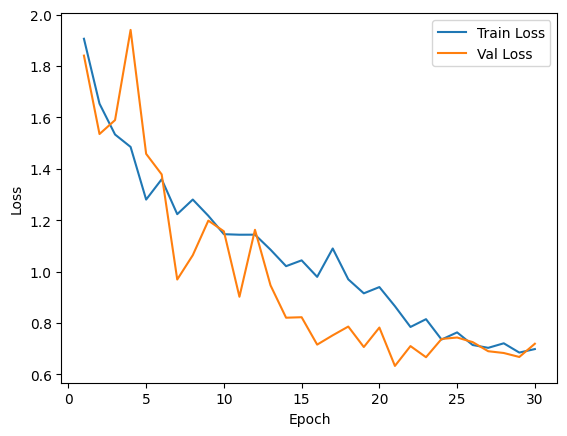

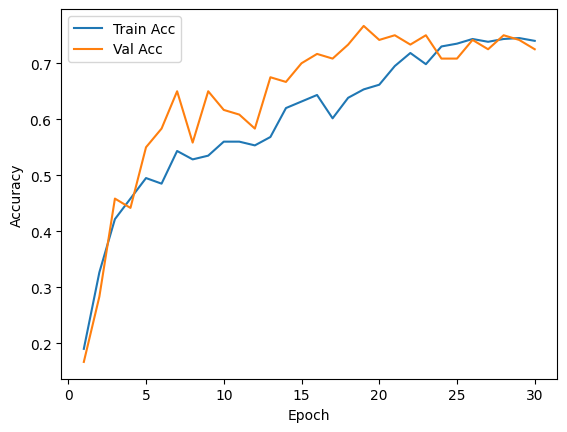

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # training mode: enables dropout and updates BatchNorm stats
    running_loss, correct, total = 0.0, 0, 0

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()             # reset gradients
        outputs = model(images)           # forward pass
        loss = criterion(outputs, targets)
        loss.backward()                   # compute gradients
        optimizer.step()                  # update weights

        # accumulate loss and accuracy stats
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)

    # average loss and accuracy for this epoch
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    print(f"Train loss: {epoch_loss:.4f}   Train acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()  # evaluation mode: disables dropout, uses running BatchNorm stats
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():  # no gradient calculation
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += images.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # compute averaged metrics
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    print(f"Test loss:  {epoch_loss:.4f}   Test acc:  {epoch_acc*100:.2f}%")

    # detailed class-by-class metrics
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    cm     = confusion_matrix(all_targets, all_preds)
    report = classification_report(all_targets, all_preds,
                                   target_names=loader.dataset.classes)
    print("Classification Report:\n", report)

    return epoch_loss, epoch_acc, cm, report


def plot_metrics(history, output_dir):
    """Save loss and accuracy curves."""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.savefig(os.path.join(output_dir, 'loss_curve.png'))

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.savefig(os.path.join(output_dir, 'acc_curve.png'))


def main():
    # --- Hyperparameters & setup ---
    epochs       = 30
    lr           = 1e-3
    weight_decay = 1e-4
    device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    output_dir   = './checkpoints'
    os.makedirs(output_dir, exist_ok=True)

    # --- Model, loss, optimizer, scheduler ---
    model = MobileNetV3('large', in_channels=3, classes=len(trainloader.dataset.classes))
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_val_acc = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # --- Training loop ---
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_one_epoch(
            model, trainloader, criterion, optimizer, device
        )
        val_loss, val_acc, cm, report = evaluate(
            model, testloader, criterion, device
        )

        scheduler.step()  # decay learning rate

        # record for plotting
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(),
                       os.path.join(output_dir, 'best_model.pth'))
            print(f"→ New best model saved (acc={best_val_acc*100:.2f}%)")

    # --- After training ---
    plot_metrics(history, output_dir)
    print("Training complete. Metrics and model saved in:", output_dir)


if __name__ == '__main__':
    main()
